In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Load your dataset
from google.colab import drive
drive.mount('/content/drive')

# Read the CSV file from your drive
file_path = '/content/drive/My Drive/dataset_1.csv' # Update with your file path
df = pd.read_csv(file_path)

# Combine 'Date' and 'Time' columns into a single datetime column
df['Date Time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set 'Date Time' as the index
df.set_index('Date Time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Separate the target variables
target_vars = ['Air Conditioner', 'Refrigerator', 'Washing Machine']
target_data = df[target_vars]


# Scaling the target data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target_data)

# Define sequence length
sequence_length = 24

# Splitting the dataset
train_size = int(len(scaled_data) * 6 / 7)  # Train on the first 6 months (approximately 86% of the data)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]  # Test on the 7th month

# Create generators
train_generator = TimeseriesGenerator(train_data, train_data, length=sequence_length, batch_size=32)
test_generator = TimeseriesGenerator(test_data, test_data, length=sequence_length, batch_size=32)

# Define LSTM model
def create_lstm_model(num_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, num_features)))
    model.add(Dense(num_features))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define GRU model
def create_gru_model(num_features):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(sequence_length, num_features)))
    model.add(Dense(num_features))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

num_features = scaled_data.shape[1]

# Create and train models
lstm_model = create_lstm_model(num_features)
gru_model = create_gru_model(num_features)
lstm_model.fit(train_generator, epochs=15, verbose=1)
gru_model.fit(train_generator, epochs=15, verbose=1)

# Ensemble Prediction with weighted average
# Assigning higher weight (0.6) to LSTM and lower weight (0.4) to GRU based on intuition
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)
ensemble_predictions = (lstm_predictions * 0.6) + (gru_predictions * 0.4)

# Inverse transform the predictions
ensemble_predictions = scaler.inverse_transform(ensemble_predictions)
test_data_inverse = scaler.inverse_transform(test_data)

# Trim the ensemble predictions and test data to 1 month
num_days = 30
num_hours = num_days * 24
ensemble_predictions = ensemble_predictions[:num_hours]
test_data_inverse = test_data_inverse[:num_hours]


Mounted at /content/drive
Epoch 1/15
135/135 [==============================] - 3s 12ms/step - loss: 0.1028
Epoch 2/15
135/135 [==============================] - 2s 12ms/step - loss: 0.0379
Epoch 3/15
135/135 [==============================] - 2s 12ms/step - loss: 0.0317
Epoch 4/15
135/135 [==============================] - 3s 18ms/step - loss: 0.0262
Epoch 5/15
135/135 [==============================] - 2s 17ms/step - loss: 0.0232
Epoch 6/15
135/135 [==============================] - 2s 12ms/step - loss: 0.0206
Epoch 7/15
135/135 [==============================] - 2s 12ms/step - loss: 0.0198
Epoch 8/15
135/135 [==============================] - 2s 12ms/step - loss: 0.0197
Epoch 9/15
135/135 [==============================] - 2s 15ms/step - loss: 0.0195
Epoch 10/15
135/135 [==============================] - 2s 18ms/step - loss: 0.0194
Epoch 11/15
135/135 [==============================] - 2s 17ms/step - loss: 0.0195
Epoch 12/15
135/135 [==============================] - 2s 12ms/step - 

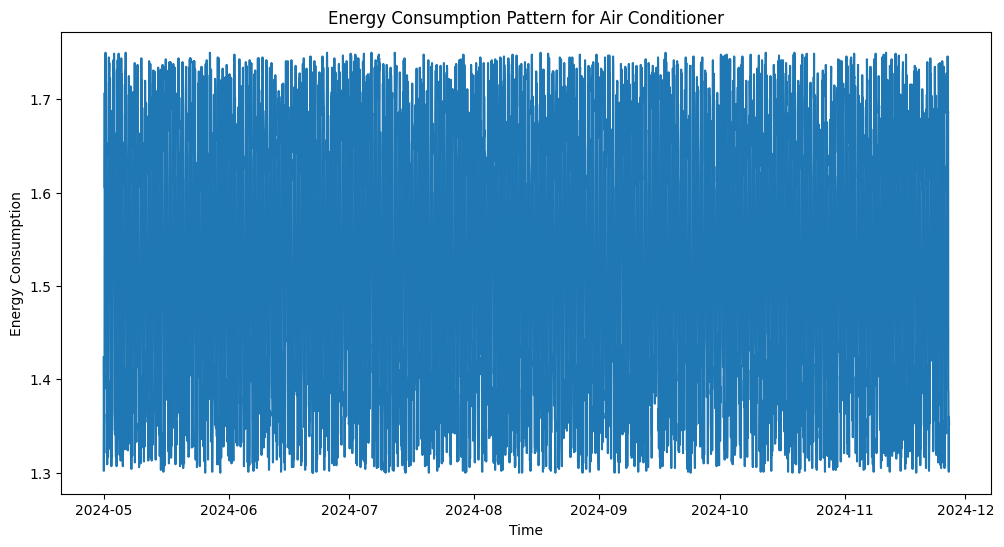

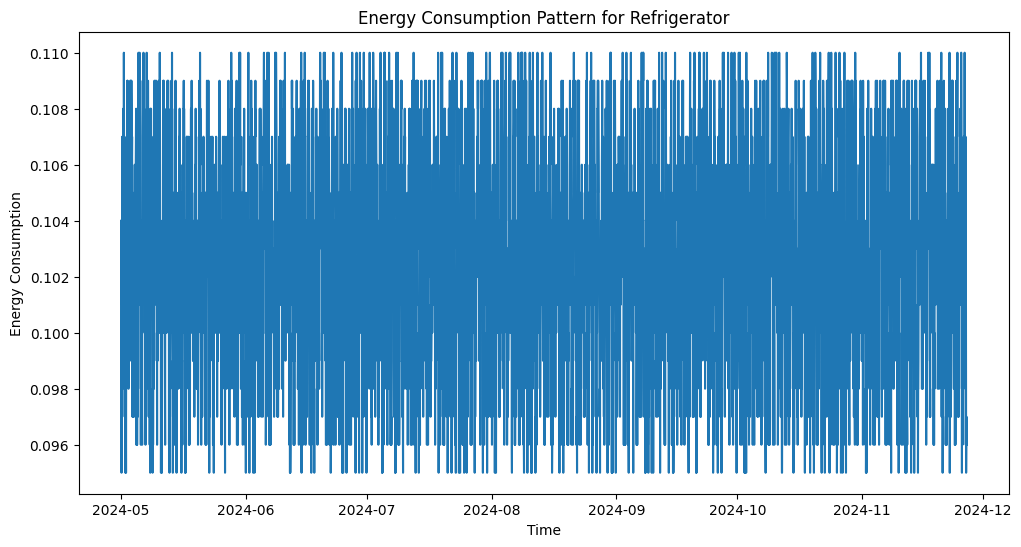

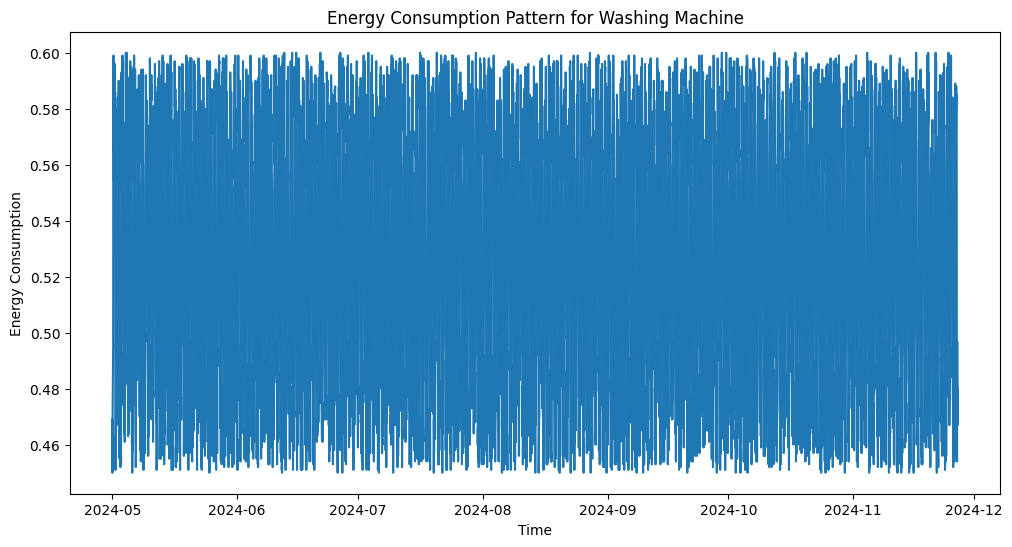

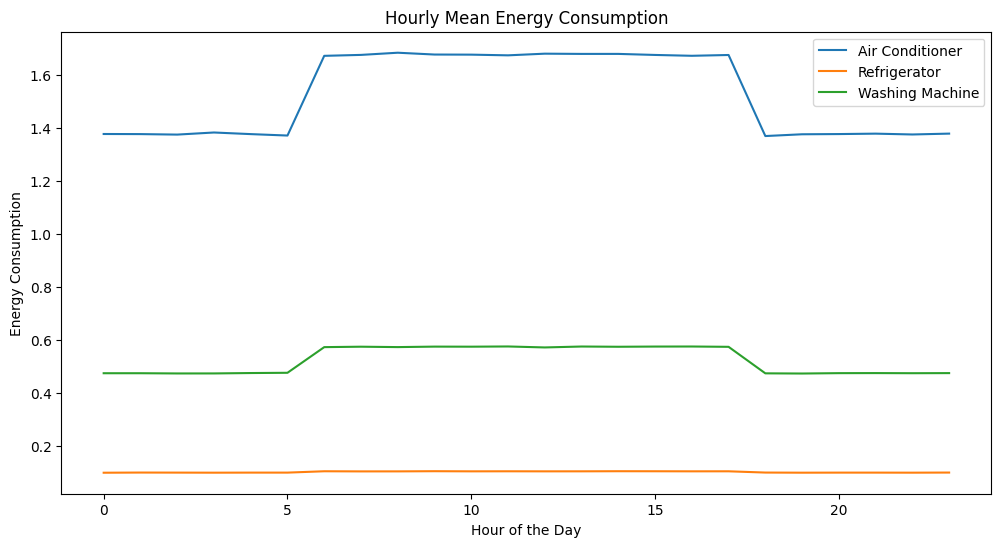

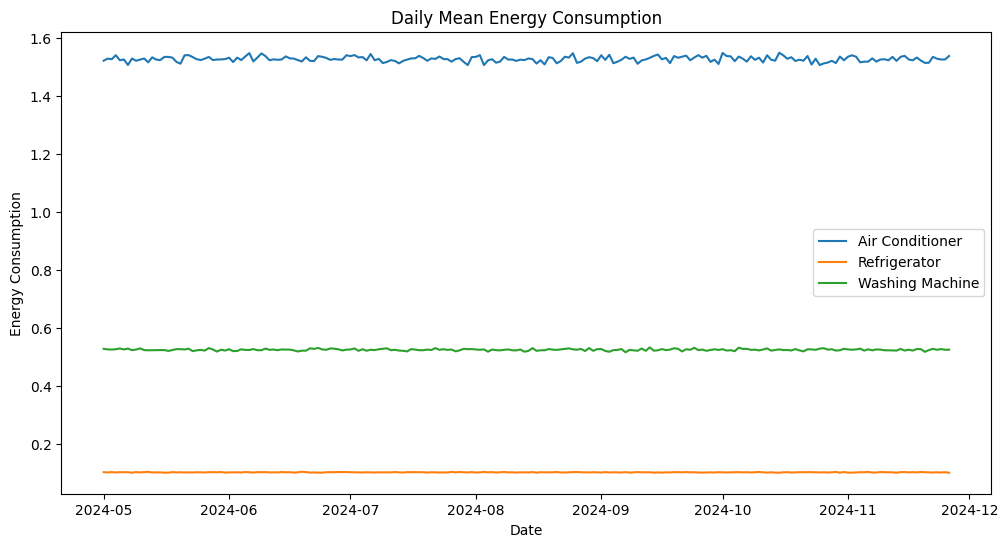

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/drive/My Drive/dataset_1.csv'  # Update with your file path
dataset = pd.read_csv(file_path)
dataset['Date Time'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])
dataset.set_index('Date Time', inplace=True)
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

# Separate the target variables
target_vars = ['Air Conditioner', 'Refrigerator', 'Washing Machine']

# Visualize the energy consumption patterns
for var in target_vars:
    plt.figure(figsize=(12, 6))
    plt.plot(dataset[var])
    plt.title(f'Energy Consumption Pattern for {var}')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.show()

# Calculate the hourly mean energy consumption
hourly_means = dataset[target_vars].groupby(dataset.index.hour).mean()

# Plot the hourly mean energy consumption
plt.figure(figsize=(12, 6))
for var in target_vars:
    plt.plot(hourly_means[var], label=var)
plt.title('Hourly Mean Energy Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Calculate the daily mean energy consumption
daily_means = dataset[target_vars].groupby(dataset.index.date).mean()

# Plot the daily mean energy consumption
plt.figure(figsize=(12, 6))
for var in target_vars:
    sns.lineplot(data=daily_means[var], label=var)
plt.title('Daily Mean Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trend hours from highest to lower usage for Air Conditioner: [8, 12, 14, 13, 9, 10, 7, 15, 17, 11, 16, 6, 3, 23, 21, 0, 20, 1, 4, 19, 22, 2, 5, 18]
Trend hours from highest to lower usage for Refrigerator: [9, 14, 15, 6, 11, 17, 13, 16, 10, 12, 8, 7, 1, 23, 18, 2, 4, 5, 21, 20, 22, 3, 19, 0]
Trend hours from highest to lower usage for Washing Machine: [11, 16, 13, 15, 9, 10, 7, 14, 17, 8, 6, 12, 5, 4, 21, 23, 20, 22, 1, 0, 18, 3, 2, 19]


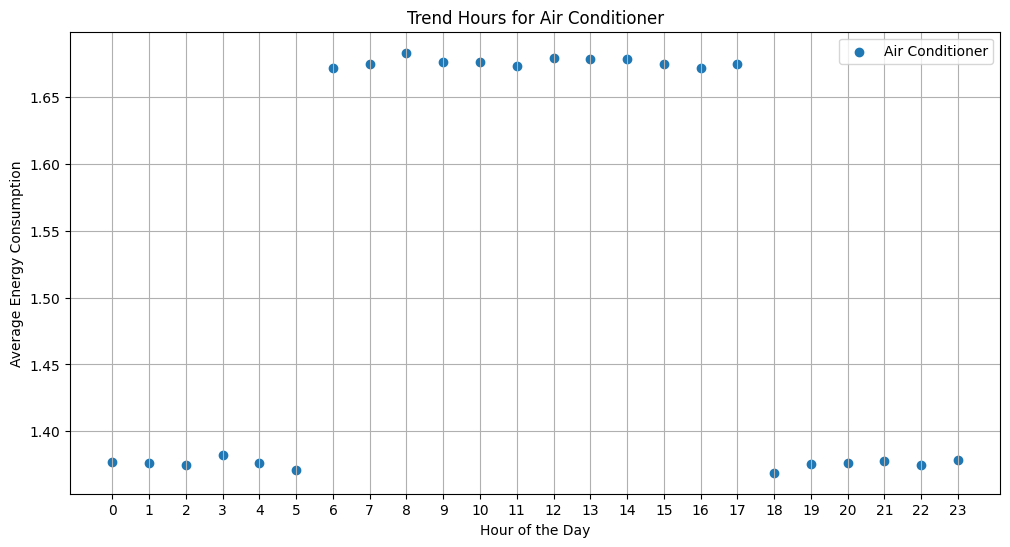

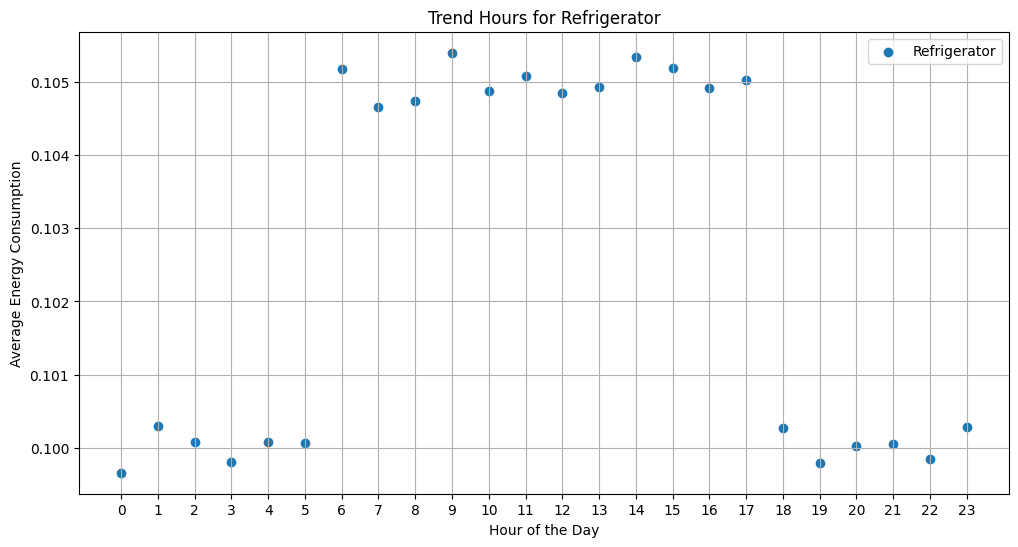

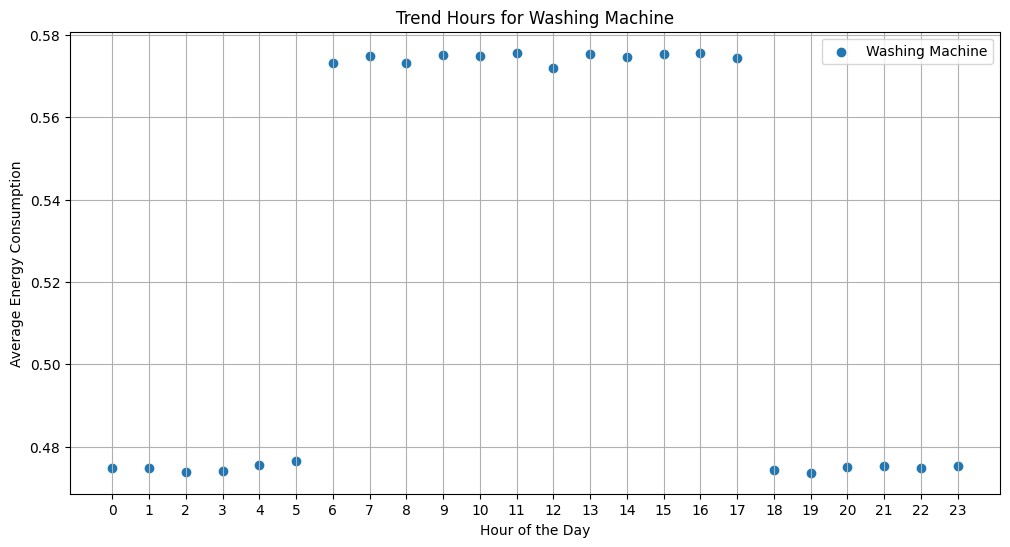

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/dataset_1.csv'  # Update with your file path
dataset = pd.read_csv(file_path)

# Combine Date and Time columns into a single Date Time column
dataset['Date Time'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])
dataset.set_index('Date Time', inplace=True)
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

# Separate the target variables
target_vars = ['Air Conditioner', 'Refrigerator', 'Washing Machine']

# Function to find trend hours
def find_trend_hours(df, appliance):
    # Group by hour and calculate the average usage
    hourly_usage = df.groupby(df.index.hour)[appliance].mean().reset_index()
    hourly_usage.columns = ['hour', appliance]  # Rename columns

    # Sort the hours by average usage in descending order
    sorted_usage = hourly_usage.sort_values(by=appliance, ascending=False).reset_index(drop=True)

    # Start with the highest usage hour
    trend_hours = [int(sorted_usage.iloc[0]['hour'])]
    previous_usage = sorted_usage.iloc[0][appliance]

    # Find subsequent hours with lower usage
    for i in range(1, len(sorted_usage)):
        current_usage = sorted_usage.iloc[i][appliance]
        if current_usage < previous_usage:
            trend_hours.append(int(sorted_usage.iloc[i]['hour']))
            previous_usage = current_usage

    return trend_hours

# Example usage
trend_hours_dict = {}
for appliance in target_vars:
    trend_hours = find_trend_hours(dataset, appliance)
    trend_hours_dict[appliance] = trend_hours
    print(f"Trend hours from highest to lower usage for {appliance}: {trend_hours}")

# Visualizing the trend hours for each appliance
for appliance in target_vars:
    hourly_usage = dataset.groupby(dataset.index.hour)[appliance].mean().reset_index()
    hourly_usage.columns = ['hour', appliance]  # Rename columns

    # Reorder based on the trend hours
    hourly_usage = hourly_usage.set_index('hour').loc[trend_hours_dict[appliance]].reset_index()

    plt.figure(figsize=(12, 6))
    plt.scatter(hourly_usage['hour'], hourly_usage[appliance], marker='o', label=appliance)
    plt.title(f'Trend Hours for {appliance}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Energy Consumption')
    plt.xticks(hourly_usage['hour'])  # Ensure all trend hours are shown on x-axis
    plt.grid(True)
    plt.legend()
    plt.show()


In [6]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

# Load your dataset
file_path = '/content/drive/My Drive/dataset_1.csv'
dataset = pd.read_csv(file_path)
dataset['Date Time'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])
dataset.set_index('Date Time', inplace=True)
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

# Separate the target variables
target_vars = ['Air Conditioner', 'Refrigerator', 'Washing Machine']
data = dataset[target_vars].values

# Normalize the data
data_norm = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Define the autoencoder model
input_dim = data_norm.shape[1]
encoding_dim = 2  # Compressed representation dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_norm, data_norm, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Compute reconstruction errors
reconstructed = autoencoder.predict(data_norm)
reconstruction_errors = np.mean(np.square(data_norm - reconstructed), axis=1)

# Set an appropriate threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies
anomalies = data[reconstruction_errors > threshold]
anomalous_timestamps = dataset.index[reconstruction_errors > threshold]

# Print the most common times when anomalies occur for each appliance
for var in target_vars:
    anomaly_hours = [timestamp.hour for timestamp in anomalous_timestamps]
    most_common_hours = sorted([(hour, anomaly_hours.count(hour)) for hour in set(anomaly_hours)], key=lambda x: x[1], reverse=True)
    print(f"Most common times for anomalies in {var}:")
    for hour, count in most_common_hours[:3]:
        print(f"{hour}:00 - {count} occurrences")
    print()

Epoch 1/50
126/126 [==============================] - 4s 14ms/step - loss: 0.1079 - val_loss: 0.0996
Epoch 2/50
126/126 [==============================] - 1s 7ms/step - loss: 0.0916 - val_loss: 0.0851
Epoch 3/50
126/126 [==============================] - 1s 6ms/step - loss: 0.0782 - val_loss: 0.0727
Epoch 4/50
126/126 [==============================] - 1s 6ms/step - loss: 0.0666 - val_loss: 0.0618
Epoch 5/50
126/126 [==============================] - 1s 5ms/step - loss: 0.0566 - val_loss: 0.0528
Epoch 6/50
126/126 [==============================] - 1s 6ms/step - loss: 0.0484 - val_loss: 0.0452
Epoch 7/50
126/126 [==============================] - 1s 5ms/step - loss: 0.0417 - val_loss: 0.0390
Epoch 8/50
126/126 [==============================] - 1s 6ms/step - loss: 0.0361 - val_loss: 0.0340
Epoch 9/50
126/126 [==============================] - 1s 11ms/step - loss: 0.0316 - val_loss: 0.0299
Epoch 10/50
126/126 [==============================] - 0s 3ms/step - loss: 0.0280 - val_loss: 0.02

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


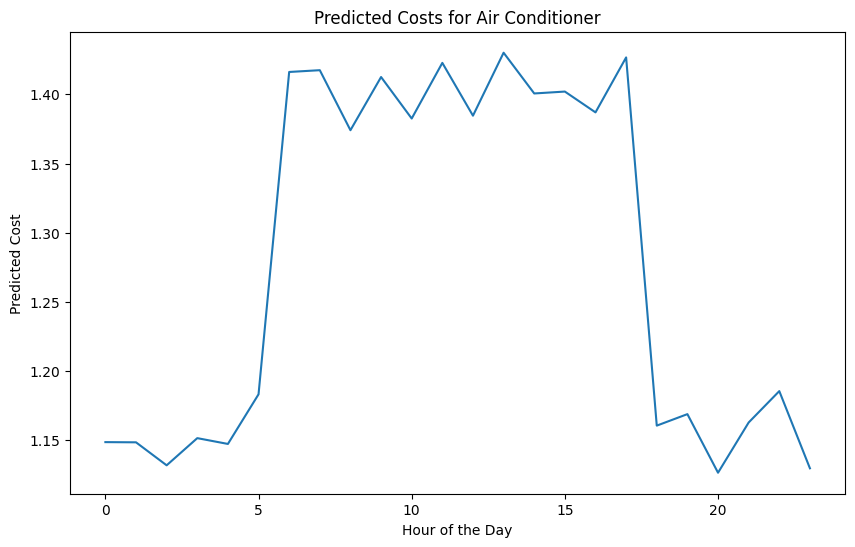

Hours to avoid using Air Conditioner: [13, 17, 11]
Total predicted cost for Air Conditioner: 30.70


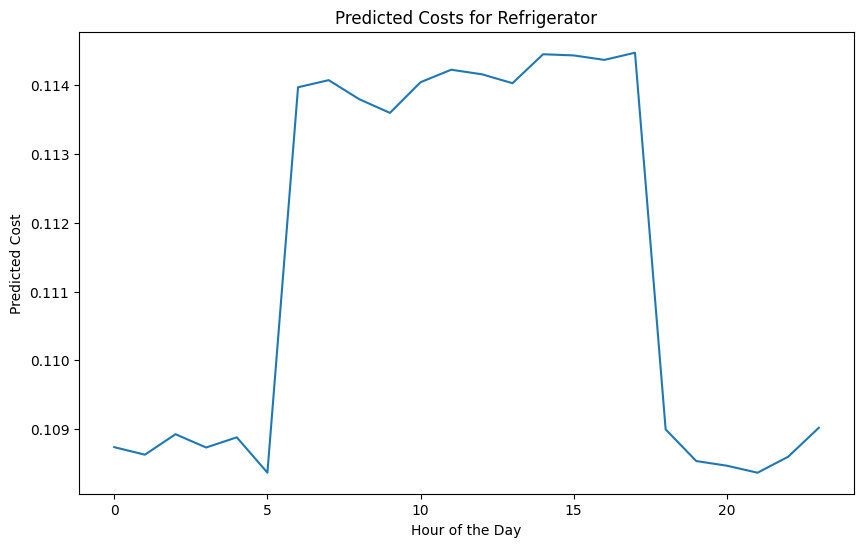

Hours to avoid using Refrigerator: [17, 14, 15]
Total predicted cost for Refrigerator: 2.67


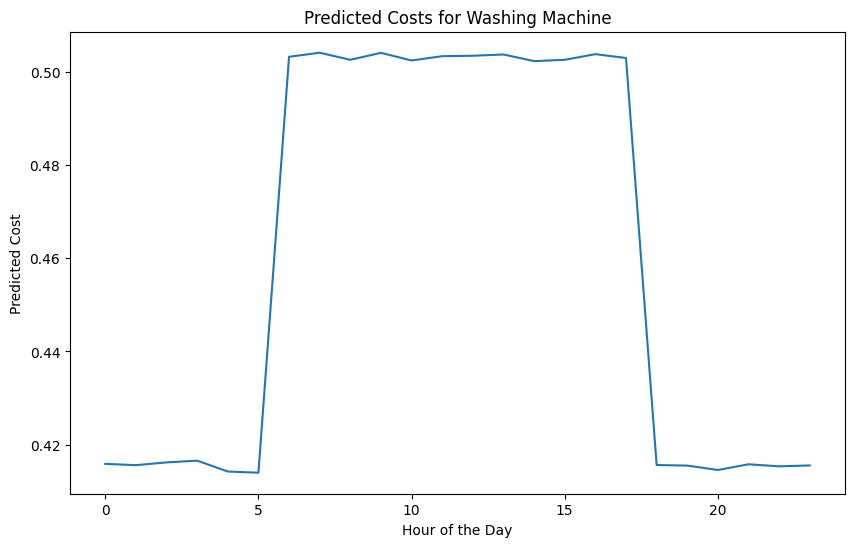

Hours to avoid using Washing Machine: [7, 9, 16]
Total predicted cost for Washing Machine: 11.02


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/dataset_1.csv'

# Load the dataset
dataset = pd.read_csv(file_path)

# Combine Date and Time columns
dataset['Date Time'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])
dataset.set_index('Date Time', inplace=True)
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

# Add hour column for later use
dataset['hour'] = dataset.index.hour

# Calculate the cost for each appliance with random variations
def calculate_cost(df, appliance):
    df['cost'] = df[appliance] * (1 + np.random.uniform(-0.2, 0.2))  # Apply random variation to all hours
    return df

# Function to forecast costs and recommend avoidance hours for the air conditioner
def forecast_and_recommend_ac(df, appliance, num_hours_to_avoid=3):
    df = calculate_cost(df.copy(), appliance)
    # Prepare the dataset for the model
    X = df[['hour', 'Temperature']]
    y = df['cost']
    # Train a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    # Predict costs for all hours
    hourly_temps = df.groupby('hour')['Temperature'].mean().reset_index()
    hourly_temps['predicted_cost'] = model.predict(hourly_temps[['hour', 'Temperature']])
    # Find the highest cost hours to avoid
    avoid_hours = hourly_temps.nlargest(num_hours_to_avoid, 'predicted_cost')['hour'].tolist()

    # Visualize predicted costs
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_temps['hour'], hourly_temps['predicted_cost'])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Predicted Cost')
    plt.title(f'Predicted Costs for {appliance}')
    plt.show()

    return avoid_hours, hourly_temps['predicted_cost'].sum()

# Function to forecast costs and recommend avoidance hours for other appliances
def forecast_and_recommend_others(df, appliance, num_hours_to_avoid=3):
    df = calculate_cost(df.copy(), appliance)
    # Prepare the dataset for the model
    X = df[['hour']]
    y = df['cost']
    # Train a Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    # Predict costs for all hours
    hourly_usage = df.groupby('hour')[appliance].mean().reset_index()
    hourly_usage['predicted_cost'] = model.predict(hourly_usage[['hour']])
    # Find the highest cost hours to avoid
    avoid_hours = hourly_usage.nlargest(num_hours_to_avoid, 'predicted_cost')['hour'].tolist()

    # Visualize predicted costs
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_usage['hour'], hourly_usage['predicted_cost'])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Predicted Cost')
    plt.title(f'Predicted Costs for {appliance}')
    plt.show()

    return avoid_hours, hourly_usage['predicted_cost'].sum()

# Example usage
appliances = ['Air Conditioner', 'Refrigerator', 'Washing Machine']
for appliance in appliances:
    if appliance == 'Air Conditioner':
        avoid_hours, total_predicted_cost = forecast_and_recommend_ac(dataset, appliance)
    else:
        avoid_hours, total_predicted_cost = forecast_and_recommend_others(dataset, appliance)
    print(f"Hours to avoid using {appliance}: {avoid_hours}")
    print(f"Total predicted cost for {appliance}: {total_predicted_cost:.2f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
135/135 [==============================] - 6s 22ms/step - loss: 0.1235
Epoch 2/20
135/135 [==============================] - 5s 34ms/step - loss: 0.0329
Epoch 3/20
135/135 [==============================] - 3s 22ms/step - loss: 0.0237
Epoch 4/20
135/135 [==============================] - 3s 22ms/step - loss: 0.0204
Epoch 5/20
135/135 [==============================] - 3s 22ms/step - loss: 0.0195
Epoch 6/20
135/135 [==============================] - 4s 30ms/step - loss: 0.0194
Epoch 7/20
135/135 [==============================] - 3s 23ms/step - loss: 0.0193
Epoch 8/20
135/135 [==============================] - 3s 22ms/step - loss: 0.0192
Epoch 9/20
135/135 [==============================] - 4s 27ms/step - loss: 0.0192
Epoch 10/20
135/135 [==============================] - 3s 26ms/step - loss: 0.0192
Epoch 11/20
135/135 [=============================

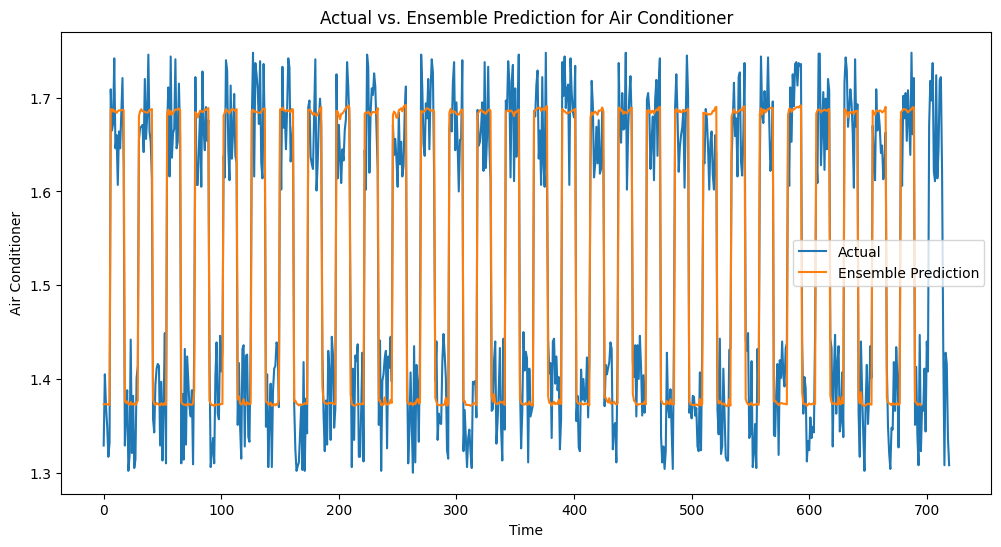

Root Mean Squared Error (RMSE) for Air Conditioner: 0.04362060539638346
R-squared (R^2) for Air Conditioner: 0.9216341059111517
Mean Absolute Error (MAE) for Air Conditioner: 0.03791723618699216
Mean Absolute Percentage Error (MAPE) for Air Conditioner: 2.5280141253954347



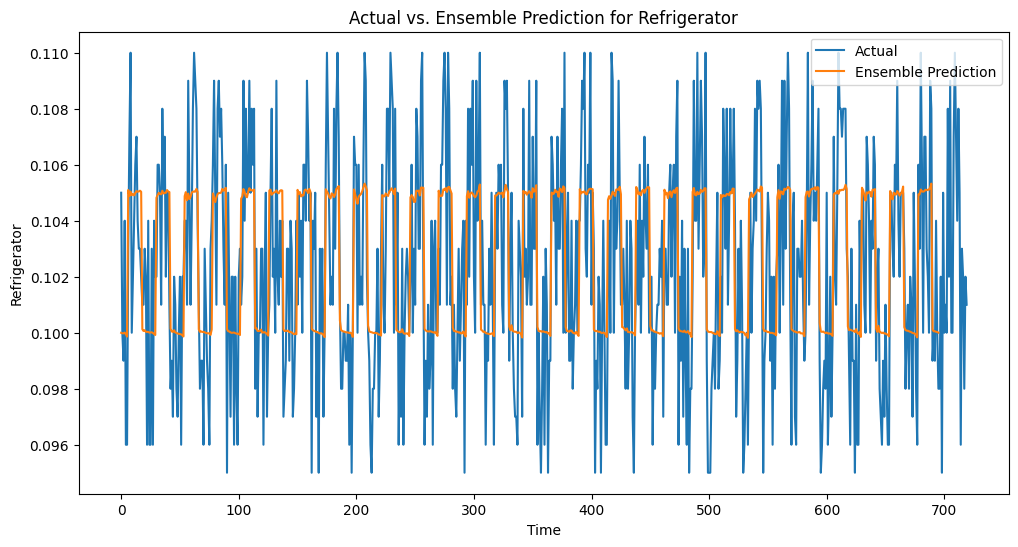

Root Mean Squared Error (RMSE) for Refrigerator: 0.0028955290927744778
R-squared (R^2) for Refrigerator: 0.44169479809332113
Mean Absolute Error (MAE) for Refrigerator: 0.0024687260404742985
Mean Absolute Percentage Error (MAPE) for Refrigerator: 2.41847570686254



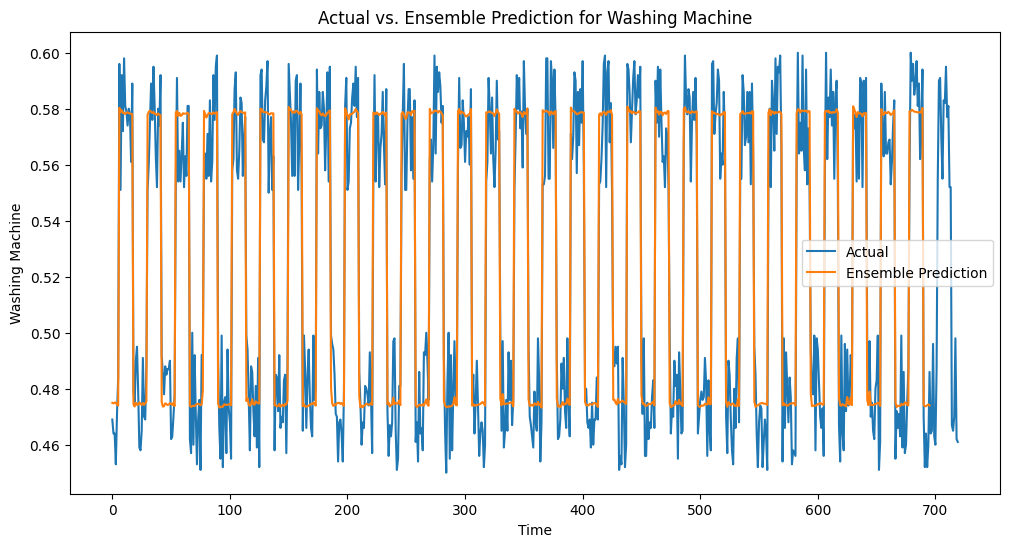

Root Mean Squared Error (RMSE) for Washing Machine: 0.014267528532003545
R-squared (R^2) for Washing Machine: 0.9259631845154772
Mean Absolute Error (MAE) for Washing Machine: 0.01222516050592235
Mean Absolute Percentage Error (MAPE) for Washing Machine: 2.351228676229722



In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Load your dataset
from google.colab import drive
drive.mount('/content/drive')

# Read the CSV file from your drive
file_path = '/content/drive/My Drive/dataset_1.csv' # Update with your file path
df = pd.read_csv(file_path)

# Combine 'Date' and 'Time' columns into a single datetime column
df['Date Time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set 'Date Time' as the index
df.set_index('Date Time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Separate the target variables
target_vars = ['Air Conditioner', 'Refrigerator', 'Washing Machine']
target_data = df[target_vars]

# Scaling the target data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target_data)

# Define sequence length
sequence_length = 24

# Splitting the dataset
train_size = int(len(scaled_data) * 6 / 7)  # Train on the first 6 months (approximately 86% of the data)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]  # Test on the 7th month

# Create generators
train_generator = TimeseriesGenerator(train_data, train_data, length=sequence_length, batch_size=32)
test_generator = TimeseriesGenerator(test_data, test_data, length=sequence_length, batch_size=32)

# Define LSTM model
def create_lstm_model(num_features):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(num_features))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define GRU model
def create_gru_model(num_features):
    model = Sequential()
    model.add(GRU(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(GRU(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(num_features))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

num_features = scaled_data.shape[1]

# Create and train models
lstm_model = create_lstm_model(num_features)
gru_model = create_gru_model(num_features)
lstm_model.fit(train_generator, epochs=20, verbose=1)
gru_model.fit(train_generator, epochs=20, verbose=1)

# Ensemble Prediction with weighted average
# Assigning higher weight (0.6) to LSTM and lower weight (0.4) to GRU based on intuition
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)
ensemble_predictions = (lstm_predictions * 0.6) + (gru_predictions * 0.4)

# Inverse transform the predictions
ensemble_predictions = scaler.inverse_transform(ensemble_predictions)
test_data_inverse = scaler.inverse_transform(test_data)

# Trim the ensemble predictions and test data to 1 month
num_days = 30
num_hours = num_days * 24
ensemble_predictions = ensemble_predictions[:num_hours]
test_data_inverse = test_data_inverse[:num_hours]

# Plot and evaluate for each target variable
for i, var in enumerate(target_vars):
    plt.figure(figsize=(12, 6))
    plt.plot(test_data_inverse[:, i], label='Actual')
    plt.plot(ensemble_predictions[:, i], label='Ensemble Prediction')
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.title(f'Actual vs. Ensemble Prediction for {var}')
    plt.legend()
    plt.show()

    # Ensure both arrays have the same length
    min_length = min(len(test_data_inverse[:, i]), len(ensemble_predictions[:, i]))
    test_data_inverse_var = test_data_inverse[:min_length, i]
    ensemble_predictions_var = ensemble_predictions[:min_length, i]

    # Calculate RMSE on the original scale
    rmse = np.sqrt(mean_squared_error(test_data_inverse_var, ensemble_predictions_var))
    print(f"Root Mean Squared Error (RMSE) for {var}: {rmse}")

    # Calculate R^2 Score on the original scale
    r2 = r2_score(test_data_inverse_var, ensemble_predictions_var)
    print(f"R-squared (R^2) for {var}: {r2}")

    # Calculate MAE on the original scale
    mae = mean_absolute_error(test_data_inverse_var, ensemble_predictions_var)
    print(f"Mean Absolute Error (MAE) for {var}: {mae}")

    # Calculate MAPE - Mean Absolute Percentage Error on the original scale
    # To avoid division by zero, make sure there are no zero values in the test_data_inverse_var
    non_zero_indices = test_data_inverse_var != 0
    mape = np.mean(np.abs((test_data_inverse_var[non_zero_indices] - ensemble_predictions_var[non_zero_indices]) / test_data_inverse_var[non_zero_indices])) * 100
    print(f"Mean Absolute Percentage Error (MAPE) for {var}: {mape}")
    print()